# Pre-Procesing

Computed Principal Components
Computed Independent Components
	Computed NDVI: Normalized Difference Vegetation Index
	Computed NDWI: Normalized Difference Water Index
	Computed BAI: Burned Area Index
	Computed BNDVI: Blue Normalized Difference Vegetation Index
	Computed CVI: Chlorophyll Vegetation Index
	Computed GNDVI: Green Normalized Difference Vegetation Index
	Computed YNDVI: Yellow Normalized Difference Vegetation Index
	Computed OSAVI: Optimized Soil-Adjusted Vegetation Index
Computed Indices
Feature Names:
Index(['coastal', 'blue', 'green', 'yellow', 'red', 'red edge', 'near IR1',
       'near IR2', 'AGL', 'PC0', 'PC1', 'PC2', 'IC0', 'IC1', 'IC2',
       'ndvi_NIR1', 'ndvi_NIR2', 'ndwi_NIR1', 'ndwi_NIR2', 'bai_NIR1',
       'bai_NIR2', 'bndvi_NIR1', 'bndvi_NIR2', 'cvi_NIR1', 'cvi_NIR2',
       'gndvi_NIR1', 'gndvi_NIR2', 'yndvi_NIR1', 'yndvi_NIR2', 'osavi_NIR1',
       'osavi_NIR2', 'CLS'],
      dtype='object')


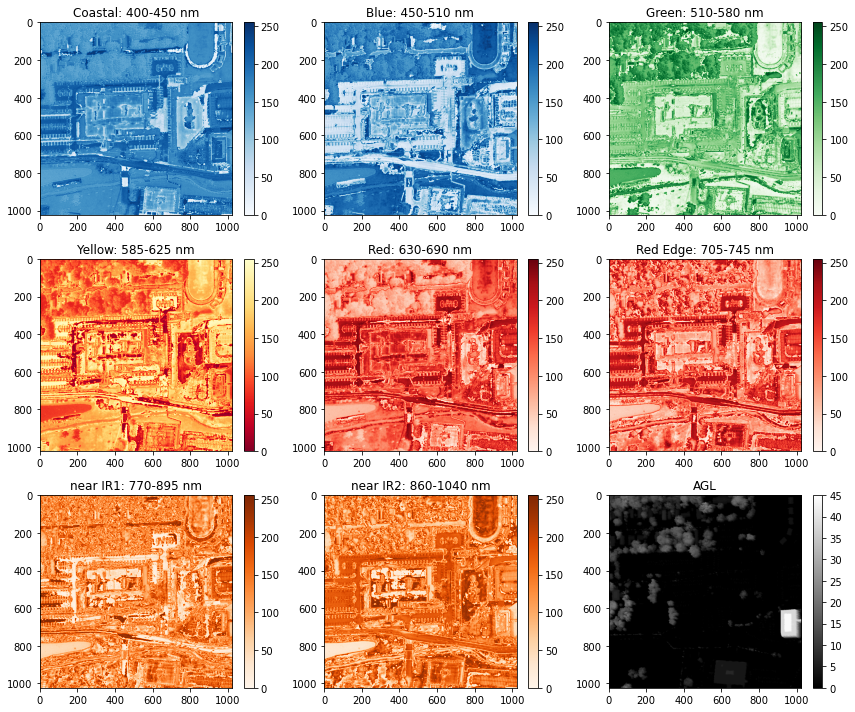

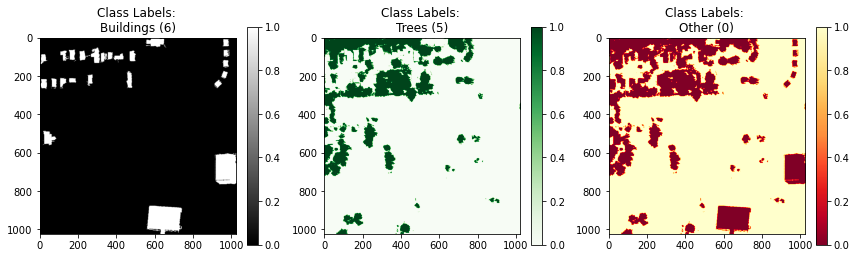

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from osgeo import gdal    ## used to read images in memory

import tensorflow as tf

################################################################
## Storing and timing Models
import pickle
from joblib import dump,load
import time

################################################################
# Custom functions from lib.py
from lib import dataExtract, dataStack, indicesFromDataStack, \
                stochasticPCAFromDataStack, stochasticICAFromDataStack, \
                stackToImage, featuresCompute, \
                vectorStackToImage, stackToImage2

################################################################
import warnings
warnings.filterwarnings("ignore")

################################################################
'''
Extract Data
'''
colNames = ['coastal','blue','green','yellow','red','red edge','near IR1', 'near IR2','AGL','CLS']
rawDataTrain = dataExtract(foldername='train')
numImages = len(rawDataTrain)

imgIdx = 1   ## index of image to plot

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(12,10))
img = ax[0][0].imshow(rawDataTrain['MSI'][imgIdx][0].astype(np.uint8), cmap='Blues'); ax[0][0].set_title('Coastal: 400-450 nm'); fig.colorbar(img, ax=ax[0][0], fraction=0.05)
img = ax[0][1].imshow(rawDataTrain['MSI'][imgIdx][1].astype(np.uint8), cmap='Blues'); ax[0][1].set_title('Blue: 450-510 nm'); fig.colorbar(img, ax=ax[0][1], fraction=0.05)
img = ax[0][2].imshow(rawDataTrain['MSI'][imgIdx][2].astype(np.uint8), cmap='Greens'); ax[0][2].set_title('Green: 510-580 nm'); fig.colorbar(img, ax=ax[0][2], fraction=0.05)
img = ax[1][0].imshow(rawDataTrain['MSI'][imgIdx][3].astype(np.uint8), cmap='YlOrRd_r'); ax[1][0].set_title('Yellow: 585-625 nm'); fig.colorbar(img, ax=ax[1][0], fraction=0.05)
img = ax[1][1].imshow(rawDataTrain['MSI'][imgIdx][4].astype(np.uint8), cmap='Reds'); ax[1][1].set_title('Red: 630-690 nm'); fig.colorbar(img, ax=ax[1][1], fraction=0.05)
img = ax[1][2].imshow(rawDataTrain['MSI'][imgIdx][5].astype(np.uint8), cmap='Reds'); ax[1][2].set_title('Red Edge: 705-745 nm'); fig.colorbar(img, ax=ax[1][2], fraction=0.05)
img = ax[2][0].imshow(rawDataTrain['MSI'][imgIdx][6].astype(np.uint8), cmap='Oranges'); ax[2][0].set_title('near IR1: 770-895 nm'); fig.colorbar(img, ax=ax[2][0], fraction=0.05)
img = ax[2][1].imshow(rawDataTrain['MSI'][imgIdx][7].astype(np.uint8), cmap='Oranges'); ax[2][1].set_title('near IR2: 860-1040 nm'); fig.colorbar(img, ax=ax[2][1], fraction=0.05)
img = ax[2][2].imshow(rawDataTrain['AGL'][imgIdx].astype(np.uint8), cmap='gray'); ax[2][2].set_title('AGL'); fig.colorbar(img, ax=ax[2][2], fraction=0.05)

fig.tight_layout()
plt.savefig('./plots/rawData.svg')

'''
Compute Features
'''
dataTrain = dataStack(rawDataTrain)
## Compute features
dataTrain = pd.DataFrame( np.array(dataTrain) , columns=colNames )
dataTrain = featuresCompute(dataTrain, numPCA=3, numICA=3 )
print(f'Feature Names:\n{dataTrain.columns}')

'''
Remove Irrelevant Classes
'''
groundTruthCLS = np.array(dataTrain['CLS'])
groundTruthCLS[np.where(groundTruthCLS==9)[0]] = 2
groundTruthCLS[np.where(groundTruthCLS==17)[0]] = 2
groundTruthCLS[np.where(groundTruthCLS==65)[0]] = 2
groundTruthCLS[np.where(groundTruthCLS==2)[0]] = 0

trainGroundTruth = vectorStackToImage(pd.DataFrame(groundTruthCLS,columns=['CLS']),colNames=['CLS'])

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
img = ax[0].imshow((trainGroundTruth['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0], fraction=0.05)
img = ax[1].imshow((trainGroundTruth['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[1].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[1], fraction=0.05)
img = ax[2].imshow((trainGroundTruth['CLS'][imgIdx]==0).astype(np.uint8), cmap='YlOrRd_r'); ax[2].set_title('Class Labels: \nOther (0)'); fig.colorbar(img, ax=ax[2], fraction=0.05)
fig.tight_layout()
plt.savefig('./plots/rawDataCLSReduced.svg')

plt.show()


## Options:
- Use best classifier from HW2, get labels and instance segment (bounding box regression)
- Use U-Net as the segmentation method: (This notebook)
- YOLOv3 or Mask R-CNN: Ignore best classifier from HW2, use ground truth labels as target, segment usin U-Net or R-CNN

In [2]:
del rawDataTrain      ## to free up space

# U-Net

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [4]:
XTrain = dataTrain.drop(columns=dataTrain.columns[-1])

In [5]:
import matplotlib

saveImg = trainGroundTruth['CLS']
for i,img in enumerate(saveImg):
    img[np.where(img==5)] = 3
    saveImg.iloc[i] = img

for i,img in enumerate(saveImg):
    matplotlib.image.imsave("trainImgCLS/trainImg_{}.jpg".format(i),img,cmap='gray')

ValueError: DataFrame constructor not properly called!

In [11]:
trainFeatureImgs = stackToImage2(XTrain,colNames = XTrain.columns)



In [ ]:
trainFeatureImgs[0]